In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle
import os

In [17]:
data = pd.read_csv("combined_data_concat.csv",header=None)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
labels = data[0]
data = data.drop(0,axis='columns')

In [18]:
unique, counts = np.unique(labels, return_counts=True)
print("Balance count: "+str(counts))

Balance count: [150 143]


In [20]:
print("Shape of data: ")
print(data.shape)

Shape of data: 
(293, 2040)


In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
def displayStats(modelname: str,truth: np.ndarray, preds: np.ndarray,softpreds = np.asarray([])):
    print(modelname+" STATS:")
    print("ACCURACY: "+str(accuracy_score(truth,preds)))


    #not all models have predict_proba
    if(softpreds.size!=0):
        print("ROC AUC: "+str(roc_auc_score(truth,softpreds)))
    
    cmat = confusion_matrix(truth,preds)
    disp = ConfusionMatrixDisplay(cmat)
    disp.plot()
    plt.show()

# Ensembling Classifier that uses the concatenated vectors and PCA to eliminate noise

---

We're going to use PCA across the entire dataset to hopefully cut out some noise. Then we are going to seperate out a fixed test set, and train multiple weak learners on the remaining data. We can then combine them, and ensemble their predictions to output a majority vote.

## First, checking the viability of PCA as a preprocessing technique
---

In [57]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data)
data_t = pca.transform(data)
print("Shape of transformed data: ")
print(data_t.shape)

Shape of transformed data: 
(293, 293)


In [65]:
X_train, holdout, y_train, holdout_labels = train_test_split(data, labels, test_size=0.30)
y_train = np.asarray(y_train.values.tolist())
y_train = y_train.reshape(-1,1)
holdout_labels = np.asarray(holdout_labels.values.tolist())
holdout_labels = holdout_labels.reshape(-1,1)

In [66]:
print(X_train.shape)
print(holdout.shape)

(205, 2040)
(88, 2040)


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30)
y_train = np.asarray(y_train.tolist())
y_train = y_train.reshape(-1,1)
y_test = np.asarray(y_test.tolist())
y_test = y_test.reshape(-1,1)

In [68]:
print(X_train.shape)
print(X_test.shape)

(143, 2040)
(62, 2040)


In [69]:
from catboost import CatBoostClassifier
cbm = CatBoostClassifier(silent=True)
cbm.fit(X_train,y_train)
preds = cbm.predict(X_test)
softpreds = cbm.predict_proba(X_test)

In [70]:
softpreds = softpreds[:,1]

CBM STATS:
ACCURACY: 0.5806451612903226
ROC AUC: 0.567398119122257


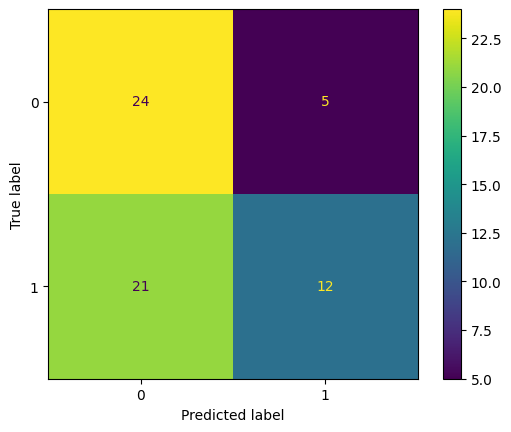

In [71]:
displayStats("CBM",y_test,preds,softpreds)

In [73]:
X_train, holdout, y_train, y_test = train_test_split(data_t, labels, test_size=0.30)
y_train = np.asarray(y_train.values.tolist())
y_train = y_train.reshape(-1,1)
y_test = np.asarray(y_test.values.tolist())
y_test = holdout_labels.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30)
y_train = np.asarray(y_train.tolist())
y_train = y_train.reshape(-1,1)
y_test = np.asarray(y_test.tolist())
y_test = y_test.reshape(-1,1)


In [ ]:
from catboost import CatBoostClassifier
cbm = CatBoostClassifier(silent=True)
cbm.fit(X_train,y_train)
preds = cbm.predict(X_test)
softpreds = cbm.predict_proba(X_test)
softpreds = softpreds[:,1]

CBM STATS:
ACCURACY: 0.6612903225806451
ROC AUC: 0.6814814814814815


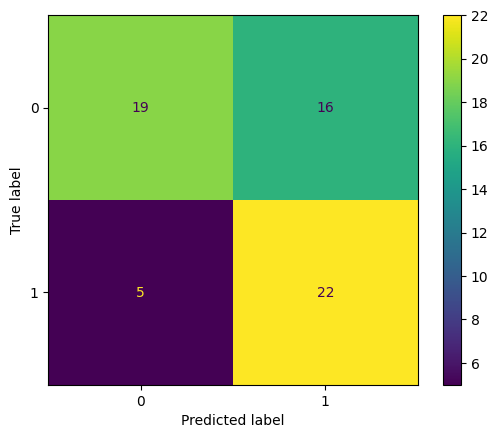

In [74]:
displayStats("CBM",y_test,preds,softpreds)

We now see that it is possible to achieve similar or better results than the raw classifier using PCA. While this does not indicate that it will guarantee a performance boost, it does show that it does not condemn the idea.

## Attempt 1 at ensembling a few classifiers

---

Voting Classifier

In [83]:
data = pd.read_csv("combined_data_concat.csv",header=None)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
labels = data[0]
data = data.drop(0,axis='columns')

In [84]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data)
data_t = pca.transform(data)
print("Shape of transformed data: ")
print(data_t.shape)

Shape of transformed data: 
(293, 293)


In [85]:
data_t, holdout, labels, holdout_labels = train_test_split(data_t, labels, test_size=0.30)
labels = np.asarray(labels.values.tolist())
labels = labels.reshape(-1,1)
holdout_labels = np.asarray(holdout_labels.values.tolist())
holdout_labels = holdout_labels.reshape(-1,1)

In [87]:
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

cbm = CatBoostClassifier(silent=True)
lreg = LogisticRegression()
gnb = GaussianNB()
knn = KNeighborsClassifier()

In [88]:
X_train, X_test, y_train, y_test = train_test_split(data_t, labels, test_size=0.30)
y_train = np.asarray(y_train.tolist())
y_train = y_train.reshape(-1,1)
y_test = np.asarray(y_test.tolist())
y_test = y_test.reshape(-1,1)
cbm.fit(X_train,y_train)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(data_t, labels, test_size=0.30)
y_train = np.asarray(y_train.tolist())
y_train = y_train.reshape(-1,1)
y_test = np.asarray(y_test.tolist())
y_test = y_test.reshape(-1,1)
lreg.fit(X_train,y_train)

/home/sidharth/Documents/School/2022_2023/EE379K_ComputerVision/final_proj/Shot-Predictor/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [92]:
X_train, X_test, y_train, y_test = train_test_split(data_t, labels, test_size=0.30)
y_train = np.asarray(y_train.tolist())
y_train = y_train.reshape(-1,1)
y_test = np.asarray(y_test.tolist())
y_test = y_test.reshape(-1,1)
gnb.fit(X_train,y_train)

/home/sidharth/Documents/School/2022_2023/EE379K_ComputerVision/final_proj/Shot-Predictor/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [93]:
X_train, X_test, y_train, y_test = train_test_split(data_t, labels, test_size=0.30)
y_train = np.asarray(y_train.tolist())
y_train = y_train.reshape(-1,1)
y_test = np.asarray(y_test.tolist())
y_test = y_test.reshape(-1,1)
knn.fit(X_train,y_train)

/home/sidharth/Documents/School/2022_2023/EE379K_ComputerVision/final_proj/Shot-Predictor/.venv/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [100]:
estimators = [
    cbm,
    lreg,
    gnb,
    knn,
]